In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import time

from sklearn.metrics import classification_report

## Load Data

In [14]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to [-1, 1]
train_images = (train_images.astype(np.float32) - 127.5) / 127.5
train_images = np.expand_dims(train_images, axis=-1)  # Add channel dimension

train_labels = train_labels.reshape(-1, 1)

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Create a tf.data.Dataset for efficient training
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))\
                                          .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Step 2: Define the Generator and Discriminator models

## Generator

In [15]:
def make_generator_model():
    """
    Conditional generator using an Embedding layer for the digit prompt.
    """
    input_noise = layers.Input(shape=(100,), name='input_noise')
    input_digit = layers.Input(shape=(1,), name='input_digit')

    digit_embedding = layers.Embedding(input_dim=10, output_dim=50)(input_digit)
    digit_embedding = layers.Flatten()(digit_embedding)

    concat = layers.Concatenate()([input_noise, digit_embedding])

    x = layers.Dense(7*7*256, use_bias=False)(concat)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 256))(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    output = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    # Note: inputs are now a list [input_noise, input_digit]
    return models.Model(inputs=[input_noise, input_digit], outputs=output)


# discriminator

In [16]:
def make_discriminator_model():
    """
    CNN-based discriminator that judges if an image is real or fake,
    conditioned on the digit label.
    """
    image_input = layers.Input(shape=(28, 28, 1))
    digit_input = layers.Input(shape=(1,))

    digit_embedding = layers.Embedding(10, 50)(digit_input)
    digit_embedding = layers.Flatten()(digit_embedding)
    dense_embedding = layers.Dense(28 * 28)(digit_embedding)
    reshaped_embedding = layers.Reshape((28, 28, 1))(dense_embedding)

    concat = layers.Concatenate()([image_input, reshaped_embedding])

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(concat)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    # Output is a single logit representing the "realness" score
    output = layers.Dense(1)(x)

    return models.Model(inputs=[image_input, digit_input], outputs=output)

## Loss and Optimizers

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # The generator wants the discriminator to think its images are real (label 1).
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)


# real prompts

In [18]:
# # Create an array of prompts corresponding to each real image
# real_prompts = train_labels.reshape(-1, 1)
# real_prompts

## Train Step

In [19]:
generator = make_generator_model()
discriminator = make_discriminator_model()

EPOCHS = 150
noise_dim = 100

# The train_step function is decorated with @tf.function to compile it
# into a high-performance graph.
@tf.function
def train_step(images, labels):
    # Use the global BATCH_SIZE, or get it dynamically if batches can vary
    current_batch_size = tf.shape(images)[0]
    noise = tf.random.normal([current_batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

## training loop

In [20]:
def train(dataset, epochs):
    # Seed for consistent image generation during training
    seed_noise = tf.random.normal([10, noise_dim])
    seed_labels = tf.constant(np.arange(10).reshape(-1, 1), dtype=tf.int64)

    # Lists to store the loss for each epoch for plotting
    generator_losses = []
    discriminator_losses = []

    for epoch in range(epochs):
        start = time.time()

        gen_loss_epoch = []
        disc_loss_epoch = []

        for image_batch, label_batch in dataset:
            g_loss, d_loss = train_step(image_batch, label_batch)
            gen_loss_epoch.append(g_loss)
            disc_loss_epoch.append(d_loss)

        # Produce images for visualization as you go
        avg_gen_loss = np.mean(gen_loss_epoch)
        avg_disc_loss = np.mean(disc_loss_epoch)

        generator_losses.append(avg_gen_loss)
        discriminator_losses.append(avg_disc_loss)

        print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec. Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}')
        generate_and_save_images(generator, epoch + 1, [seed_noise, seed_labels])

    return generator_losses, discriminator_losses


def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10, 1))

    for i in range(predictions.shape[0]):
        plt.subplot(1, 10, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Image at epoch {epoch}')
    plt.show()



## def Generate Images

In [21]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10, 1))

    for i in range(predictions.shape[0]):
        plt.subplot(1, 10, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Image at epoch {epoch}')
    plt.show()


# Train

In [22]:
# --- Run the training ---
gen_losses, disc_losses = train(train_dataset, EPOCHS)

Output hidden; open in https://colab.research.google.com to view.

## Training History

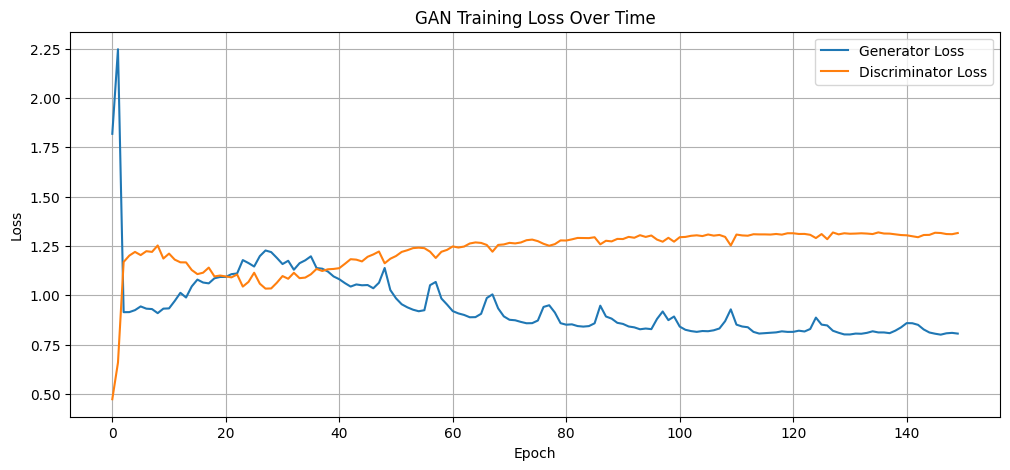

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Test Generation

\nGenerating final images...


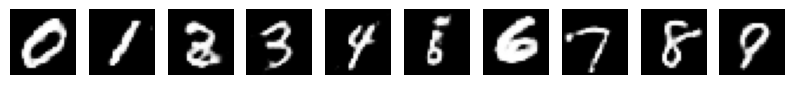

In [25]:
print("\\nGenerating final images...")
num_examples_to_generate = 10
random_noise = tf.random.normal([num_examples_to_generate, 100])
prompts = np.arange(10).reshape(-1, 1)

# Convert numpy array to a tensor to avoid mixed types error
prompts_tensor = tf.convert_to_tensor(prompts)

final_images = generator([random_noise, prompts_tensor], training=False)

plt.figure(figsize=(10, 1))
for i in range(num_examples_to_generate):
    plt.subplot(1, 10, i + 1)
    plt.imshow(final_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.show()

**Observations**

+ with matrix of prompt, 200 epochs did very well with with definition of numbers but generates the incorrect numbers
+ with matrix of prompt didn't do that well at 50 epochs, showed sign of improving,
+ with 1 value for the prompt seemed ok at predicting with 50 epochs

In [26]:
generator.save('/content/gdrive/MyDrive/01. Projects/01. Experimental Playground/07. Youtube/46. Digits Generator/generator4.h5')

In [27]:
discriminator.save('/content/gdrive/MyDrive/01. Projects/01. Experimental Playground/07. Youtube/46. Digits Generator/discriminator4.h5')